##Imports

In [97]:
import numpy as np
from numpy import genfromtxt
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import mahalanobis

## Loading and Normalizing Data

In [95]:
penguins = genfromtxt('penguins.csv', delimiter = ',')
quake = genfromtxt('quake.csv', delimiter = ',')

In [94]:
np.random.seed(120)
np.random.shuffle(penguins)
np.random.shuffle(quake)

In [96]:
pmax = np.max(penguins, axis = 0, keepdims = True)
pmin = np.min(penguins, axis = 0, keepdims = True)
qmax = np.max(quake, axis = 0, keepdims = True)
qmin = np.min(quake, axis = 0, keepdims = True)
pset = (penguins - pmin)/(pmax - pmin)
pset = pset[ : , : -1]
qset = (quake - qmin)/(qmax - qmin)

In [ ]:
print(qset.shape)
print(pset.shape)

(2178, 2)
(333, 4)


## K means

In [59]:
def get_Hmeans_score(data, distance, link, center):
  hmeans = AgglomerativeClustering(n_clusters=center, metric=distance, linkage=link)
  model = hmeans.fit_predict(qset)
  score = davies_bouldin_score(qset, model)
  return score

### Euclidean Distance

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

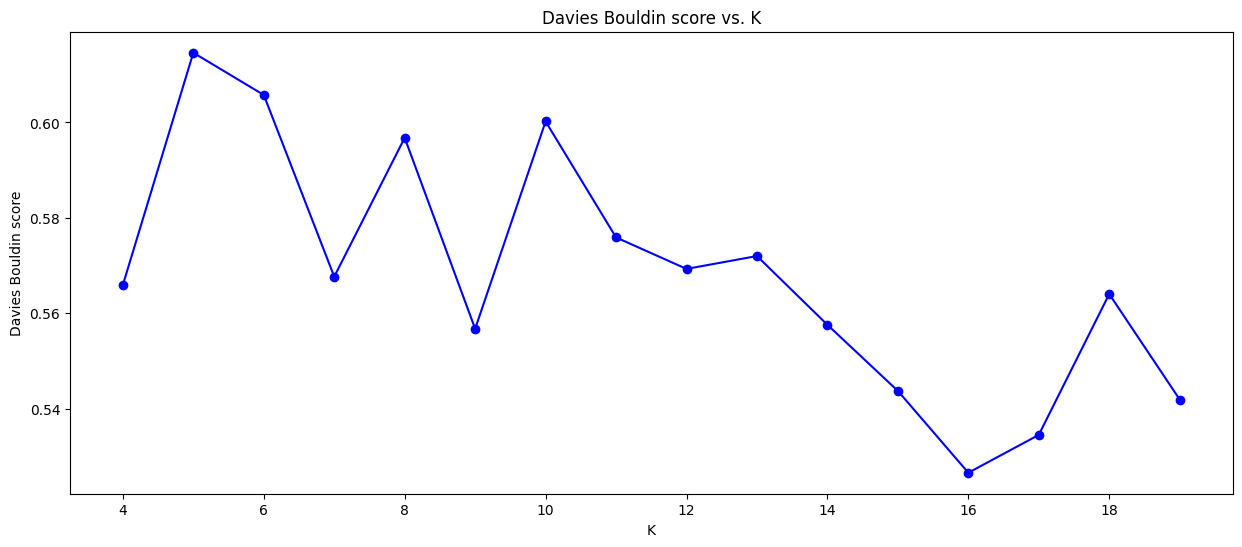

In [8]:
centers = list(range(4, 20))
avg_scores = []
for center in centers:
  avg_scores.append(get_Hmeans_score(qset, 'euclidean', 'average', center))

plt.figure(figsize=(15,6));
plt.plot(centers, avg_scores, linestyle='-', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. K')

In [23]:
kmeans = KMeans(n_clusters=5, random_state=42, init='random', n_init=20, algorithm='lloyd')

In [28]:
labels = kmeans.fit_predict(qset)

In [43]:
labels = np.array(labels).reshape(-1, 1)

In [46]:
final_ds = np.hstack((qset, labels))

In [49]:
df = pd.DataFrame(final_ds, columns = ['col_1', 'col_2', 'label'])

<Axes: xlabel='col_1', ylabel='col_2'>

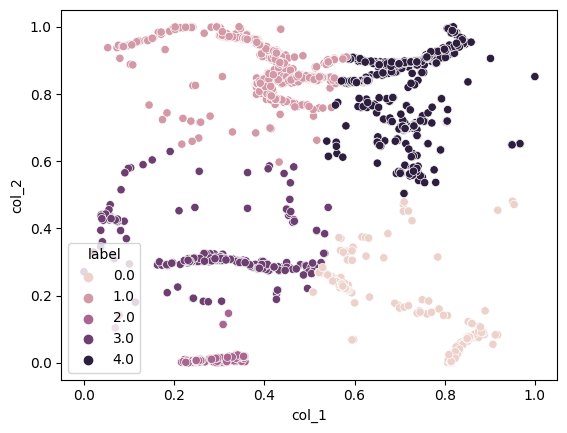

In [60]:
sns.scatterplot(data=df, x="col_1", y="col_2", hue="label")

### Mahalanobis Distance

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

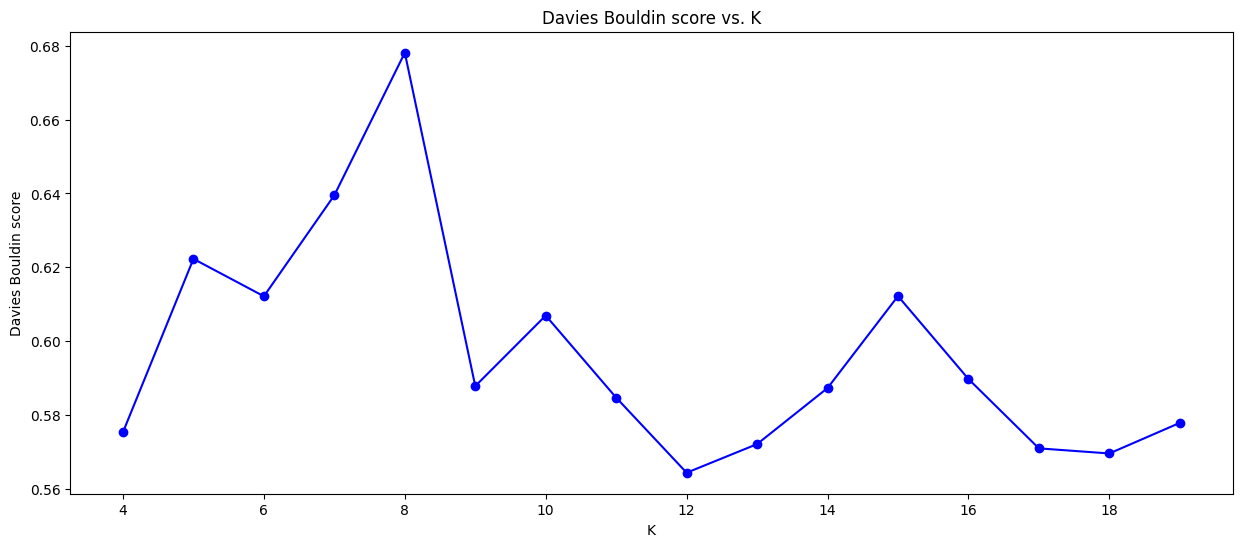

In [62]:
centers = list(range(4, 20))
avg_scores = []
for center in centers:
  avg_scores.append(get_Hmeans_score(qset, 'mahalanobis', 'average', center))

plt.figure(figsize=(15,6));
plt.plot(centers, avg_scores, linestyle='-', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. K')

In [78]:
def mahalanobis_distance(x, y, covariance_inv):
    return mahalanobis(x, y, covariance_inv)

def kmeans_mahalanobis(X, k, max_iterations=100):

    centroids_idx = np.random.choice(X.shape[0], size=k, replace=False)
    centroids = X[centroids_idx]

    for _ in range(max_iterations):
        # Mahalanobis distance for each point and each centroid
        covariance = np.cov(X.T)
        covariance_inv = np.linalg.inv(covariance)
        distances = np.array([mahalanobis_distance(x, centroid, covariance_inv) for x in X for centroid in centroids])
        distances = distances.reshape(len(X), k)

        # Assign data points to the nearest centroid
        cluster_labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([np.mean(X[cluster_labels == i], axis=0) for i in range(k)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    # Reconstruction error
    squared_distances = np.array([np.sum((X[i] - centroids[cluster_labels[i]]) ** 2) for i in range(len(X))])
    reconstruction_error = np.sum(squared_distances)

    return centroids, cluster_labels, reconstruction_error

In [84]:
min_reconstruction_error = np.inf
labels = []
best_centroids = []
best_iter = 0

for i in range(20):
  centroids, cluster_labels, reconstruction_error = kmeans_mahalanobis(qset, 8)
  if reconstruction_error < min_reconstruction_error:
    min_reconstruction_error = reconstruction_error
    best_iter = i
    best_centroids = centroids
    labels = cluster_labels


In [86]:
labels = np.array(labels).reshape(-1, 1)

In [87]:
final_ds = np.hstack((qset, labels))

In [88]:
df = pd.DataFrame(final_ds, columns = ['col_1', 'col_2', 'label'])

<Axes: xlabel='col_1', ylabel='col_2'>

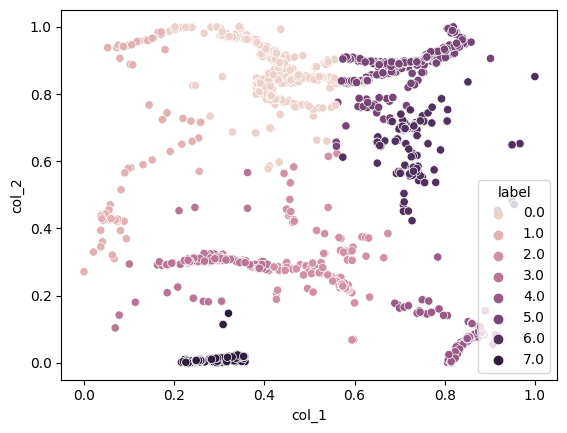

In [90]:
sns.scatterplot(data=df, x="col_1", y="col_2", hue="label", legend="full")

## Principal Components Analysis (PCA)

In [106]:
def PCA(ds, M):
  n_samples = ds.shape[0]
  mean = np.mean(ds, axis = 0)
  temp = ds - mean
  cov = np.sum(np.apply_along_axis(func1d = lambda x: np.outer(x, x), axis = 1, arr = temp), axis = 0)/(n_samples-1)
  val, vec = np.linalg.eig(cov)
  idx = np.argsort(val)
  m_val = val[idx[-M : ]]
  P = vec[idx[-M : ]]
  Z = P @ ds.T
  exp_var = np.sum(m_val)
  return Z, exp_var

In [107]:
Z_1, EV1 = PCA(pset, 1)
Z_2, EV2 = PCA(pset, 2)
Z_3, EV3 = PCA(pset, 3)
Z_4, EV4 = PCA(pset, 4)

<function matplotlib.pyplot.show(close=None, block=None)>

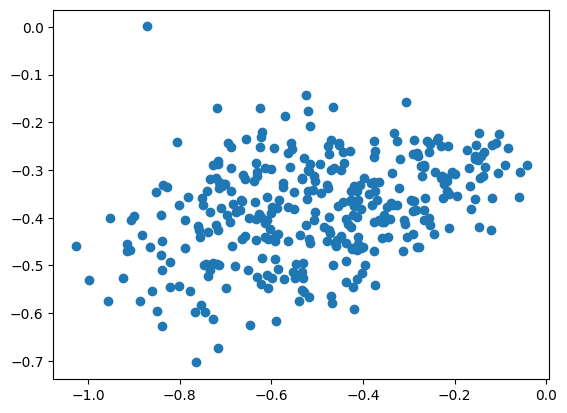

In [108]:
plt.scatter(Z_2[0], Z_2[1])
plt.show

In [109]:
print("Variância explidada:")
print(f"1 dimension projection: {EV1}")
print(f"2 dimensions projection: {EV2}")
print(f"3 dimensions projection: {EV3}")
print(f"4 dimensions projection: {EV4}")

Variância explidada:
1 dimension projection: 0.13992555145892083
2 dimensions projection: 0.17844709752107096
3 dimensions projection: 0.1951886824832248
4 dimensions projection: 0.20096558216954585
